In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# ntuple file here
file = uproot.open('/eos/cms/store/group/dpg_hgcal/comm_hgcal/hackathon/samples/close_by_double_pion/production/ntuples_10454408_0.root')

In [3]:
file.keys()
file.classnames()

{'ntuplizer': 'TDirectory',
 'ntuplizer/simtrackstersSC': 'TTree',
 'ntuplizer/simtrackstersCP': 'TTree',
 'ntuplizer/tracksters': 'TTree',
 'ntuplizer/clusters': 'TTree',
 'ntuplizer/graph': 'TTree',
 'ntuplizer/candidates': 'TTree',
 'ntuplizer/trackstersMerged': 'TTree',
 'ntuplizer/associations': 'TTree',
 'ntuplizer/tracks': 'TTree'}

In [4]:
trackstersclue3d = file["ntuplizer/tracksters"]
simtrackstersCP = file["ntuplizer/simtrackstersCP"]
graph = file["ntuplizer/graph"]
associations = file["ntuplizer/associations"]
candidates = file["ntuplizer/candidates"]
candidates.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
NCandidates          | unknown                  | <UnknownInterpretation 'non...
candidate_charge     | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
candidate_pdgId      | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
candidate_id_prob... | std::vector<std::vect... | AsObjects(AsVector(True, As...
candidate_time       | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
candidate_timeErr    | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
candidate_energy     | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
candidate_px         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
candidate_py         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
candidate_pz         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
track_in_candidate   | std::

In [5]:
# Get ntuples from tree in file
tracksterN = trackstersclue3d["NTracksters"].array(library='np')
x = trackstersclue3d["barycenter_x"].array(library='np')
y = trackstersclue3d["barycenter_y"].array(library='np')
z = trackstersclue3d["barycenter_z"].array(library='np')
linkedInners = graph["linked_inners"].array(library='np')
linkedOuters = graph["linked_outers"].array(library='np')
trackstersInCandidate = candidates["tracksters_in_candidate"].array(library='np')
simTracksters_CP_N = simtrackstersCP["stsCP_NTracksters"].array(library='np')
tsAssocMap = associations["tsCLUE3D_recoToSim_CP"].array(library='np')
tsAssocQual = associations["tsCLUE3D_recoToSim_CP_score"].array(library='np')

In [18]:
# Print ntuples
event_to_visualize = 180
print("N tracksters (CLU3D): ", tracksterN[event_to_visualize])
#print("trackster indices: ", indices[event_to_visualize])
print("", z[event_to_visualize])
#print(linkedInners[event_to_visualize])
#print(linkedOuters[event_to_visualize])
print("ts in candidate:   ", trackstersInCandidate[event_to_visualize])
print("ts Reco-Sim assoc: ", tsAssocMap[event_to_visualize])
print("assoc quality:     ", tsAssocQual[event_to_visualize])
print("N SimTrackster (from CP):", simTracksters_CP_N[event_to_visualize])

N tracksters (CLU3D):  42
 [332.7373  339.64017 340.9786  341.5328  348.36603 350.1982  348.36194
 354.05905 359.96603 365.9956  362.2741  369.81586 365.93533 366.2379
 371.51266 371.5298  376.6688  375.8378  379.48352 376.51346 369.0021
 393.0425  382.30637 385.5738  388.21793 402.02448 398.53735 390.4943
 386.85788 394.73956 389.97116 407.69983 401.93283 398.60898 397.449
 402.1444  402.85907 401.99203 398.85284 410.91425 450.25378 504.75916]
ts in candidate:    [[0, 40, 19], [1, 20, 35, 14, 10, 41], ..., [36], [37]]
ts Reco-Sim assoc:  [[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], ..., [0, 1], [0, 1], [1, 0], [1, 0], [1, 0]]
assoc quality:      [[0.99982995, 3.73207e-05], [0.98726696, 0.00011397576], ..., [1.0, 0.0], [1.0, 0.0]]
N SimTrackster (from CP): 2


In [35]:
# Truth graph
nodes_truth = []
edges_truth = []
ts_best_matches = []
assoc_threshold = 0.1
to_same = []

        
for i in range(tracksterN[event_to_visualize]):
    nodes_truth.append(i)
    #qualities = np.array(tsAssocQual[event_to_visualize][i])
    qualities = tsAssocQual[event_to_visualize][i]
    best_score = np.amin(qualities) #lowest score
    #assocmapnp = np.array(tsAssocMap[event_to_visualize][i])
    assocmapnp = tsAssocMap[event_to_visualize][i]
    best_score_sts = assocmapnp[np.argmin(qualities)] #sts with the lowest score
    if best_score < assoc_threshold:
        ts_best_matches.append(best_score_sts)
    else:
        ts_best_matches.append(-1)
        
        
for sts in range(simTracksters_CP_N[event_to_visualize]+1):
    to_same.append([])
print("Best matches [ts, sts]: ", ts_best_matches)
for ts, sts in enumerate(ts_best_matches):
    to_same[sts].append(ts)

# tracksters not truth-matched are put in the last element of to_same 
print("associated to_same:", to_same)

for ts_list in to_same[:-1]:
    for idx, a in enumerate(ts_list):
        for b in ts_list[idx + 1:]:
            edges_truth.append([a,b])
print("truth edges: ", edges_truth)

Best matches [ts, sts]:  [0, 0, 1, -1, -1, 1, -1, 0, 1, 0, 0, -1, 1, 0, 0, 0, -1, -1, 1, 0, 0, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 1, -1, 1, 0, 0, 0]
associated to_same: [[0, 1, 7, 9, 10, 13, 14, 15, 19, 20, 35, 39, 40, 41], [2, 5, 8, 12, 18, 21, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 38], [3, 4, 6, 11, 16, 17, 22, 23, 28, 37]]
truth edges:  244


In [38]:
# TICLGraph
edges = []
nodes = []
# pos in R-z, nx can't take 3D 
pos = {i:(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i]))) for i in range(tracksterN[event_to_visualize])}
for i in range(tracksterN[event_to_visualize]):
    nodes.append(i)
    #print(np.size(linkedInners[event_to_visualize][i]))
    for j in linkedInners[event_to_visualize][i]:
        edges.append([j,i])
print("number of TICLGraph edges: ", len(edges))
        
# TICLGraph truth
# label TICLGraph edge 1 if the two edges are from the same CP
# else 0
edgesTICLtruth = []
# pos in R-z, nx can't take 3D 
pos = {i:(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i]))) for i in range(tracksterN[event_to_visualize])}
for i in range(tracksterN[event_to_visualize]):
    nodesTICLtruth.append(i)
    #print(np.size(linkedInners[event_to_visualize][i]))
    for j in linkedInners[event_to_visualize][i]:
        if ts_best_matches[i] == ts_best_matches[j]:
            edgesTICLtruth.append(1)
        else:
            edgesTICLtruth.append(0)
print(len(edgesTICLtruth))

# from TICLCandidates (linking)
edgesFromCandidate = []
NCandidates = 0
trackster_to_cand_map = [i for i in range(tracksterN[event_to_visualize])]
for i in trackstersInCandidate[event_to_visualize]:
    NCandidates+=1
    print(i)
    if np.size(i) <= 1:
        continue;
    else:
        for idx, j in enumerate(i):
            for k in i[idx+1:]:
                #print (j, k)
                edgesFromCandidate.append([j,k])
            trackster_to_cand_map[j] = NCandidates-1
#print("edges from candidate: ", edgesFromCandidate)
print("ts - cand map: ", trackster_to_cand_map)

number of TICLGraph edges:  343
343
[0, 40, 19]
[1, 20, 35, 14, 10, 41]
[2, 8, 31, 38, 25, 12, 24, 33, 18]
[3, 23, 39, 15]
[4, 30, 9, 17]
[5]
[6, 22]
[7]
[11, 28]
[27]
[13, 16]
[21, 29, 34]
[26]
[32]
[36]
[37]
ts - cand map:  [0, 1, 2, 3, 4, 5, 6, 7, 2, 4, 1, 8, 2, 10, 1, 3, 10, 4, 2, 0, 1, 11, 6, 3, 2, 2, 26, 27, 8, 11, 4, 2, 32, 2, 11, 1, 36, 37, 2, 3, 0, 1]


In [21]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

TruthG = nx.Graph()
TruthG.add_nodes_from(nodes_truth)
TruthG.add_edges_from(edges_truth)

candidateG = nx.Graph()
candidateG.add_nodes_from(nodes)
candidateG.add_edges_from(edgesFromCandidate)

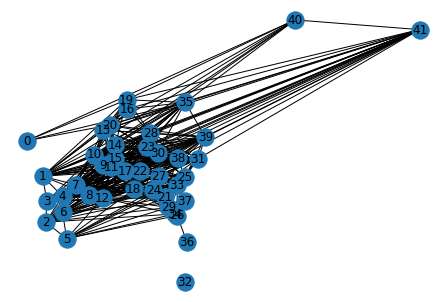

In [22]:
# TICLGraph
nx.draw(G,pos=pos, with_labels=True)

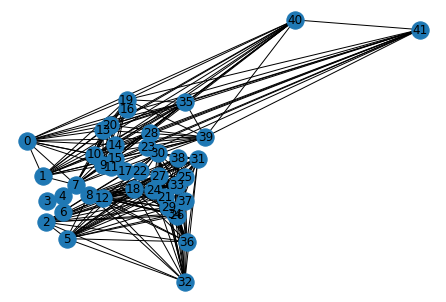

In [23]:
# Truth Graph
nx.draw(TruthG,pos=pos, with_labels=True)

In [24]:
# Graph from TICL Candidate (geometric linking)
#nx.draw(candidateG, with_labels=True)

3  not matched
4  not matched
6  not matched
11  not matched
16  not matched
17  not matched
22  not matched
23  not matched
28  not matched
37  not matched


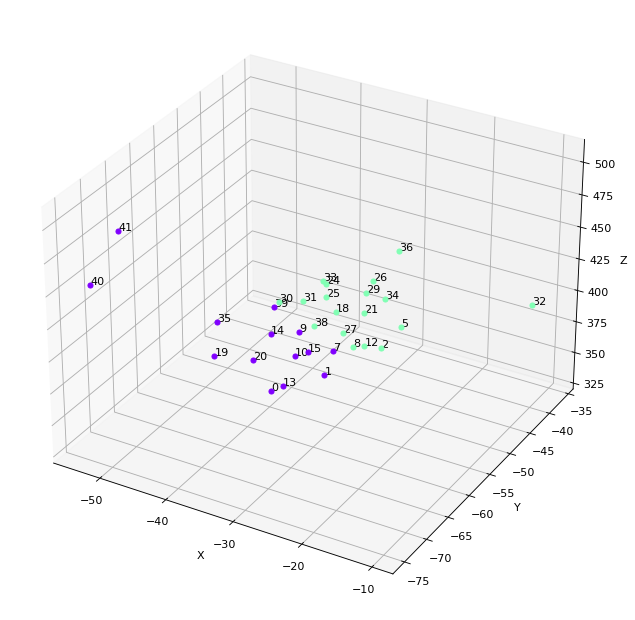

In [25]:
# CLUE3D Tracksters in 3D-cartesian coordinates
# colors represent ts->sts associations

fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=simTracksters_CP_N[event_to_visualize])

for i in range(tracksterN[event_to_visualize]):
    if ts_best_matches[i][1] == -1:
        print(i, " not matched")
        continue
    ax.scatter(x[event_to_visualize][i],y[event_to_visualize][i],z[event_to_visualize][i], color=cmap(norm(ts_best_matches[i])[1]))
    ax.text(x[event_to_visualize][i],y[event_to_visualize][i],z[event_to_visualize][i], '%s' % (str(i)), zorder=1, color='k')
plt.show()

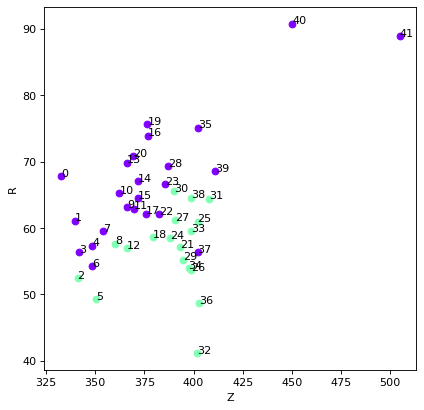

In [26]:
# in R-z, similar to the graph
# colors represent ts->sts associations

fig = plt.figure(figsize=(6,6), dpi=80)
ax = fig.add_subplot()
ax.set_xlabel('Z')
ax.set_ylabel('R')

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), color=cmap(norm(ts_best_matches[i][1])))
    ax.text(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), '%s' %(str(i)), zorder=1, color='k')

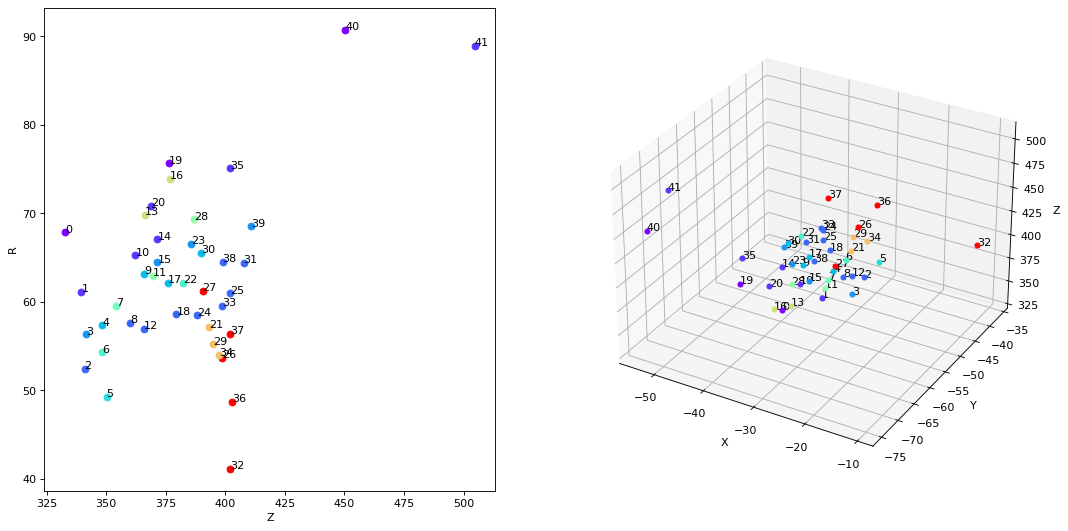

In [27]:
# in R-z, similar to the graph -> Geometric linking
# colors represent ts->sts associations

fig = plt.figure(figsize=(16,8), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Z')
ax.set_ylabel('R')
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=NCandidates-1)

for i in range(tracksterN[event_to_visualize]):
    ax.scatter(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), color=cmap(norm(trackster_to_cand_map[i])))
    ax.text(z[event_to_visualize][i], np.sqrt(np.square(x[event_to_visualize][i]) + np.square(y[event_to_visualize][i])), '%s' %(str(i)), zorder=1, color='k')
    
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for i in range(tracksterN[event_to_visualize]):
    ax.scatter(x[event_to_visualize][i], y[event_to_visualize][i], z[event_to_visualize][i], color=cmap(norm(trackster_to_cand_map[i])))
    ax.text(x[event_to_visualize][i], y[event_to_visualize][i], z[event_to_visualize][i], '%s' %(str(i)), zorder=1, color='k')